In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/olid2019/test_a_tweets_all.tsv
/kaggle/input/olid2019/testset-levela.tsv
/kaggle/input/olid2019/olid-training-v1.0.tsv
/kaggle/input/olid2019/test_a_tweets.tsv
/kaggle/input/olid2019/labels-levela.csv
/kaggle/input/olid2019/test_a_labels_all.csv
/kaggle/input/olid2019/test_a_labels.csv


# load and merge dataset

In [2]:
import csv
labelData =  pd.read_csv('../input/olid2019/test_a_labels.csv')
labelData.columns = ['id','status']
tweetData = pd.read_table('../input/olid2019/test_a_tweets.tsv')
newData = pd.concat([labelData, tweetData],axis = 1)
newData = newData.drop(['id','id'], axis = 1)
newData.head()

,status,tweet
0,OFF,¿Who the fuck is Yoru?
1,NOT,@USER @USER He's an evil law breaker that shou...
2,NOT,Now hiring for 49 #Labor job opportunities in ...
3,NOT,"#NerkondaPaarvai' - As Of Now, There Is NO Ear..."
4,NOT,"@USER Hahahaha I wish...but a week is good, I’..."


# Lowercase

In [3]:
newData['tweet'] = newData['tweet'].str.lower()


# Data Preprocessing 

cleaning, tokenization, stop word removal, lemmatization

In [4]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

#remove punctuation
newData['tweet'] = newData['tweet'].str.replace(r'[^\w\s]+', '')
#word tokenization
newData['tweet'] = newData.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)
#remove stopwords
newData['tweet'] = newData['tweet'].apply(lambda x: [item for item in x if item not in stop])
#lemmatization
newData['tweet'] = newData['tweet'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
#join sentence
newData['tweet'] = newData['tweet'].apply(lambda x: (" ").join(x))



newData.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,status,tweet
0,OFF,fuck yoru
1,NOT,user user he evil law breaker prison criminal ...
2,NOT,hiring 49 labor job opportunity minnesota clic...
3,NOT,nerkondapaarvai early morning show coimbatore ...
4,NOT,user hahahaha wishbut week good im extremely h...


# Level Encoding

In [5]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
newData['status']= label_encoder.fit_transform(newData['status'])
 
newData['status']


0       1
1       0
2       0
3       0
4       0
       ..
3882    0
3883    0
3884    1
3885    1
3886    2
Name: status, Length: 3887, dtype: int64

In [6]:
X = newData[['tweet']]
y = newData[['status']]
X

,tweet
0,fuck yoru
1,user user he evil law breaker prison criminal ...
2,hiring 49 labor job opportunity minnesota clic...
3,nerkondapaarvai early morning show coimbatore ...
4,user hahahaha wishbut week good im extremely h...
...,...
3882,rt stan exot9 follow everyone rts make sure fo...
3883,think maybe designed alone
3884,user user user user user q csia would function...
3885,user parent jail childabuse jesus christ poor ...


# Type Conversion

In [7]:
y = y.astype(np.int16)

# Test Train Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
#tf idf
tf_idf = TfidfVectorizer()
#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(X_train.loc[:, 'tweet'].values).astype(np.int16)
#applying tf idf to training data
X_test_tf = tf_idf.transform(X_test.loc[:, 'tweet'].values).astype(np.int16)

In [11]:
cntVec = CountVectorizer()
X_train_vec = cntVec.fit_transform(X_train.loc[:, 'tweet'].values).astype(np.int16)
X_test_vec = cntVec.transform(X_test.loc[:, 'tweet'].values).astype(np.int16)

In [12]:
import matplotlib.pyplot as plt

# logistic regression, Naive-bayes (Count Vectorization)

In [13]:
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [14]:
#logistic regression
modelLR = LogisticRegression(random_state = 1)
modelLR.fit(X_train_vec, y_train)

train_acc = modelLR.score(X_train_vec, y_train)
print("Logistic Regression: The Accuracy for Training Set is {}".format(train_acc*100))
print('\n')
#naive bayes
modelNB = ComplementNB()
modelNB.fit(X_train_vec, y_train)
train_acc_nb = modelNB.score(X_train_vec, y_train)
print("Naive Bayes: The Accuracy for Training Set is {}".format(train_acc_nb*100))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression: The Accuracy for Training Set is 95.17529752331939


Naive Bayes: The Accuracy for Training Set is 88.54937278867803


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
#logistic regression
y_pred = modelLR.predict(X_test_vec) 
test_acc = accuracy_score(y_test, y_pred)
print("Logistic Regression: The Accuracy for Test Set is {}".format(test_acc*100))
print(classification_report(y_test, modelLR.predict(X_test_vec), target_names=['offensive', 'not-offensive']))
print('\n')
#naivebayes


y_pred = modelNB.predict(X_test_vec) 
test_acc_nb = accuracy_score(y_test, y_pred)
print("Naive Bayes: The Accuracy for Test Set is {}".format(test_acc_nb*100))
print(classification_report(y_test, modelLR.predict(X_test_vec), target_names=['offensive', 'not-offensive']))

Logistic Regression: The Accuracy for Test Set is 66.19537275064268
               precision    recall  f1-score   support

    offensive       0.71      0.89      0.79       559
not-offensive       0.23      0.08      0.12       219

     accuracy                           0.66       778
    macro avg       0.47      0.49      0.46       778
 weighted avg       0.57      0.66      0.60       778



Naive Bayes: The Accuracy for Test Set is 65.55269922879178
               precision    recall  f1-score   support

    offensive       0.71      0.89      0.79       559
not-offensive       0.23      0.08      0.12       219

     accuracy                           0.66       778
    macro avg       0.47      0.49      0.46       778
 weighted avg       0.57      0.66      0.60       778



# logistic regression, Naive-bayes (TF-IDF)

In [16]:
#logistic regression
modelLR = LogisticRegression(random_state = 1)
modelLR.fit(X_train_tf, y_train)

train_acc_tf = modelLR.score(X_train_tf, y_train)
print("Logistic Regression: The Accuracy for Training Set is {}".format(train_acc_tf*100))
print('\n')
#naive bayes
modelNB = ComplementNB()
modelNB.fit(X_train_tf, y_train)
train_acc_nb_tf = modelNB.score(X_train_tf, y_train)
print("Naive Bayes: The Accuracy for Training Set is {}".format(train_acc_nb_tf*100))

Logistic Regression: The Accuracy for Training Set is 72.30620778385332


Naive Bayes: The Accuracy for Training Set is 72.30620778385332


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
#logistic regression
y_pred = modelLR.predict(X_test_tf) 
test_acc_tf = accuracy_score(y_test, y_pred)
print("Logistic Regression: The Accuracy for Test Set is {}".format(test_acc_tf*100))
print(classification_report(y_test, modelLR.predict(X_test_tf), target_names=['offensive', 'not-offensive']))

print('\n')
#naivebayes


y_pred = modelNB.predict(X_test_tf) 
test_acc_nb_tf = accuracy_score(y_test, y_pred)
print("Naive Bayes: The Accuracy for Test Set is {}".format(test_acc_nb_tf*100))
print(classification_report(y_test, modelNB.predict(X_test_tf), target_names=['offensive', 'not-offensive']))

Logistic Regression: The Accuracy for Test Set is 71.8508997429306
               precision    recall  f1-score   support

    offensive       0.72      1.00      0.84       559
not-offensive       0.00      0.00      0.00       219

     accuracy                           0.72       778
    macro avg       0.36      0.50      0.42       778
 weighted avg       0.52      0.72      0.60       778



Naive Bayes: The Accuracy for Test Set is 71.8508997429306
               precision    recall  f1-score   support

    offensive       0.72      0.99      0.84       559
not-offensive       0.50      0.01      0.03       219

     accuracy                           0.72       778
    macro avg       0.61      0.50      0.43       778
 weighted avg       0.66      0.72      0.61       778



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


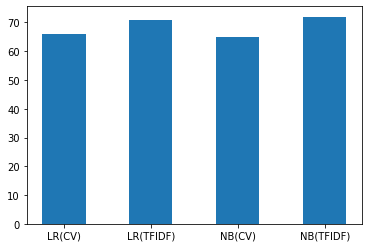

In [18]:
x = np.array(["LR(CV)","LR(TFIDF)", "NB(CV)","NB(TFIDF)"])
y = np.array([int(test_acc*100), int(test_acc_tf*100), int(test_acc_nb*100), int(train_acc_nb_tf*100)])
plt.bar(x,y,width = 0.5)
plt.show()

# RNN with pooling layer

In [19]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['tweet'])
X_train = tokenizer.texts_to_sequences(X_train['tweet'])
X_test = tokenizer.texts_to_sequences(X_test['tweet'])
vocab_size = len(tokenizer.word_index) + 1

In [20]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [21]:
embedding_dim = 100
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,'r', encoding="utf8") as f:
        for line in f:
            txt = line.split()
            word, vector = txt[0], txt[1:]
           
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_matrix = create_embedding_matrix('../input/glove6b100dtxt/glove.6B.100d.txt',tokenizer.word_index, embedding_dim)

In [22]:
from keras.models import Sequential
from keras import layers
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          653100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 654,121
Trainable params: 654,121
Non-trainable params: 0
_________________________________________________________________


2022-05-15 15:45:50.227369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:45:50.375564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:45:50.376510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:45:50.378066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

2022-05-15 15:45:53.564768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [24]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy (RNN with pooling layer): {:.4f}".format(accuracy*100))
loss, accuracyRNN = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy (RNN with pooling layer):  {:.4f}".format(accuracyRNN*100))

98/98 - 0s - loss: -6.1419e-02 - accuracy: 0.9977
Training Accuracy (RNN with pooling layer): 99.7748
25/25 - 0s - loss: 4.4028 - accuracy: 0.6440
Testing Accuracy (RNN with pooling layer):  64.3959


# LSTM

In [25]:
from keras.layers import LSTM, embeddings, Dense

In [26]:
np.random.seed(7)

In [27]:
from keras.models import Sequential
from keras import layers
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=500, 
                           trainable=True))
model.add(LSTM(100))

model.add(Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          653100    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 734,521
Trainable params: 734,521
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

2022-05-15 15:47:19.194984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [29]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy (LSTM): {:.4f}".format(accuracy*100))
loss, accuracyLSTM = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy (LSTM):  {:.4f}".format(accuracyLSTM*100))

98/98 - 0s - loss: 0.5905 - accuracy: 0.7231
Training Accuracy (LSTM): 72.3062
25/25 - 0s - loss: 0.5944 - accuracy: 0.7185
Testing Accuracy (LSTM):  71.8509


In [30]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [31]:
maxlen = 200
batch_size = 128 
model = Sequential()
model.add(Embedding(vocab_size, batch_size, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          835968    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 936,085
Trainable params: 936,085
Non-trainable params: 0
________________________________________________

In [32]:
history=model.fit(X_train, y_train,
           batch_size=batch_size,
           epochs=50,
           validation_data=[X_test, y_test])

Epoch 1/50
25/25 [==============================] - 4s 36ms/step - loss: 0.6301 - accuracy: 0.7086 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
25/25 [==============================] - 0s 15ms/step - loss: 0.6063 - accuracy: 0.7218 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/50
25/25 [==============================] - 0s 15ms/step - loss: 0.5883 - accuracy: 0.7224 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/50
25/25 [==============================] - 0s 14ms/step - loss: 0.5495 - accuracy: 0.7231 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/50
25/25 [==============================] - 0s 15ms/step - loss: 0.9435 - accuracy: 0.7147 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/50
25/25 [==============================] - 0s 15ms/step - loss: 0.5199 - accuracy: 0.7459 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/50
25/25 [==============================] - 0s 15ms/step - loss: 0.4328 - accuracy: 0.8051 - val_l

In [33]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy (BiLSTM): {:.4f}".format(accuracy*100))
loss, accuracyBL = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy (BiLSTM):  {:.4f}".format(accuracyBL*100))


98/98 - 1s - loss: -2.5519e-03 - accuracy: 0.9965
Training Accuracy (BiLSTM): 99.6462
25/25 - 0s - loss: 4.0408 - accuracy: 0.6247
Testing Accuracy (BiLSTM):  62.4679


# Neural Network

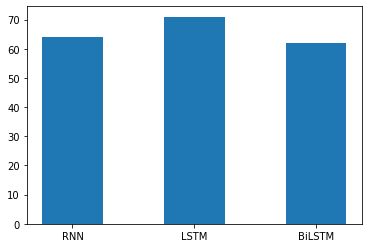

In [34]:
x = np.array(["RNN","LSTM", "BiLSTM"])
y = np.array([int(accuracyRNN*100), int(accuracyLSTM*100), int(accuracyBL*100)])
plt.bar(x,y,width = 0.5)
plt.show()

# All Model

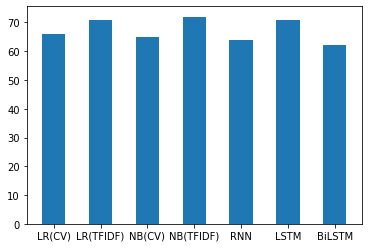

In [35]:
x = np.array(["LR(CV)","LR(TFIDF)", "NB(CV)","NB(TFIDF)","RNN","LSTM", "BiLSTM"])
y = np.array([int(test_acc*100), int(test_acc_tf*100), int(test_acc_nb*100), int(train_acc_nb_tf*100),int(accuracyRNN*100), int(accuracyLSTM*100), int(accuracyBL*100)])
plt.bar(x,y,width = 0.5)
plt.show()